In [25]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional, Dict, Any, Union, Callable, Iterable

In [ ]:
from scaling.utils import (
    get_pareto_frontier, 
    get_final_points_from_curve_set, 
    fit_linear_model,
    functional_form_chin3,
    fit_parametric_form,
)
from scaling.visualize import visualize_train_curves, plot_line_fit

In [ ]:
warmstarting_df = pd.read_parquet(
    "../data/warmstarting_results.parquet",
)
display(warmstarting_df)

In [ ]:
# retaining only warmstarting results

warmstarting_df = warmstarting_df.loc[warmstarting_df.method != "mup"]
display(warmstarting_df)

### Visualize raw data

Visualize all learning curves across N, D available in the *training set* to see scaling patterns.

Optionally, consider visualizing for different hyperparameters.

In [ ]:
unique_col_list = ["base_N", "target_N", "tkpm", "shrink"]
y_col = "Validation Loss"
x_col = "flops"  # "tokens"

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(6, 4))

pareto_df = visualize_train_curves(
    ax, 
    warmstarting_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    plot_all_curves=True,
    plot_final=True,
    plot_pareto_final=True,
    ylims=(1.5, 2.5),
    xlims=(1e16, 2e19),
    xlog=True,
)

### Approach 1

Fit for `C vs N` and `C vs D`, assuming *best* training run for each `(N, D)`.

Steps:

1. Visualize for `C vs N` and `C vs D`
2. Fit linear model for each of them

In [ ]:
x_col = "flops"
y_col = "Validation Loss"

_pareto_df = get_final_points_from_curve_set(
    warmstarting_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)

display(_pareto_df.head())

plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

plot_line_fit(
    ax[0],
    X = _pareto_df[x_col],
    Y = _pareto_df["target_N"]
)
ax[0].set_ylabel("Target N")

plot_line_fit(
    ax[1],
    X = _pareto_df[x_col],
    Y = _pareto_df["tokens"],
)
ax[1].set_ylabel("Tokens")

plot_line_fit(
    ax[2],
    X = _pareto_df[x_col],
    Y = _pareto_df[y_col],
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()


##### Using the largest model scale as the held out

In [ ]:
# Creating held out over pareto df HERE

train_df = _pareto_df.loc[_pareto_df.target_N != sorted(_pareto_df.target_N.unique())[-1]]
held_out_df = _pareto_df.loc[_pareto_df.target_N == sorted(_pareto_df.target_N.unique())[-1]]
held_out_df

In [ ]:
# Visualizing scaling law linear fit for C vs N, D, L

plt.clf();
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5));

# C vs N

X = train_df[x_col].values
Y = train_df["target_N"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[0],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df["target_N"].values[0]],
)
ax[0].set_ylabel("Target N")


# C vs D

X = train_df[x_col].values
Y = train_df["tokens"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[1],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df.tokens.values[0]],
)
ax[1].set_ylabel("Tokens")

# C vs Loss

X = train_df[x_col].values
Y = train_df[y_col].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[2],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df[y_col].values[0]],
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

handles, labels = ax[0].get_legend_handles_labels()
for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()
fig.legend(handles, labels, loc="upper center", ncol=4)

##### Using the top-2 model scales as the held out

In [ ]:
# Creating held out over pareto df HERE

train_df = _pareto_df.loc[_pareto_df.target_N.isin(sorted(_pareto_df.target_N.unique())[:-2])]
held_out_df = _pareto_df.loc[_pareto_df.target_N.isin(sorted(_pareto_df.target_N.unique())[-2:])]
held_out_df = held_out_df.loc[held_out_df.tkpm.isin(train_df.tkpm.unique())]
held_out_df

In [ ]:
# Visualizing scaling law linear fit for C vs N, D, L

plt.clf();
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5));

# C vs N

X = train_df[x_col].values
Y = train_df["target_N"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[0],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values.tolist() + [1e20, 1e21, 1e22, 1e23],
    y_extrapolate=held_out_df["target_N"].values,
)
ax[0].set_ylabel("Target N")


# C vs D

X = train_df[x_col].values
Y = train_df["tokens"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[1],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values.tolist() + [1e20, 1e21, 1e22, 1e23],
    y_extrapolate=held_out_df.tokens.values,
)
ax[1].set_ylabel("Tokens")

# C vs Loss

X = train_df[x_col].values
Y = train_df[y_col].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[2],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values.tolist() + [1e20, 1e21, 1e22, 1e23],
    y_extrapolate=held_out_df[y_col].values,
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

handles, labels = ax[0].get_legend_handles_labels()
for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()
fig.legend(handles, labels, loc="upper center", ncol=4)

#### Fixed Base Model

In [13]:
# Visualize the Pareto Front and display to what algorithm it belongs (I think we just have muP and Paws...)

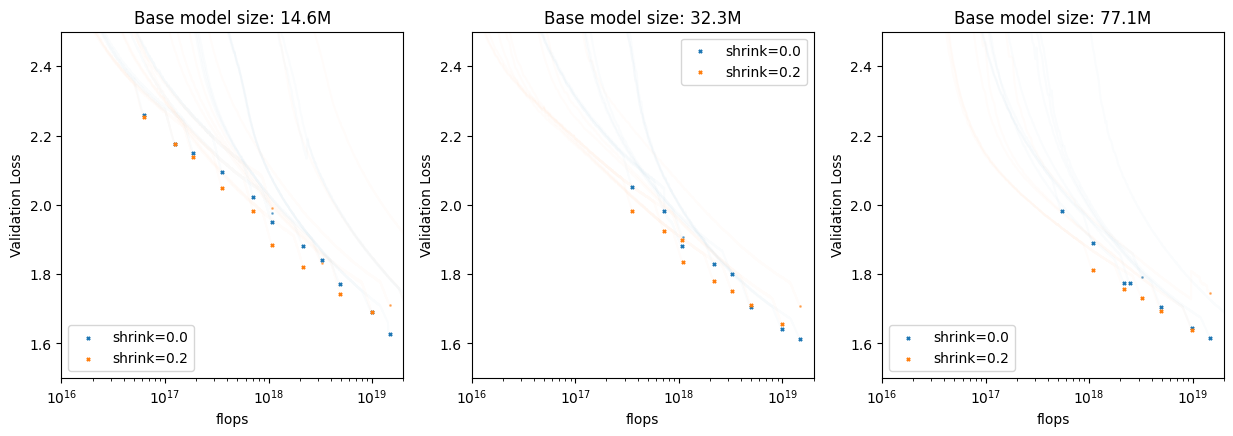

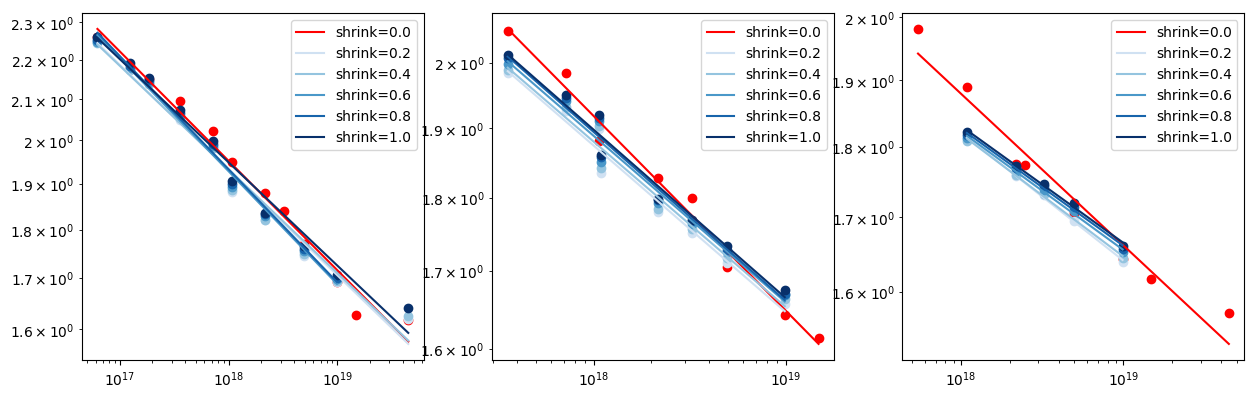

In [19]:
warmstarting_df = pd.read_parquet(
    "../data/warmstarting_results.parquet",
)
base_model_sizes = warmstarting_df['base_N'].unique()

# create a plot with len(basemodel sizes) many axes
fig, axes = plt.subplots(1, len(base_model_sizes), figsize=(5 * len(base_model_sizes), 4.5));
fig2, axes2 = plt.subplots(1, len(base_model_sizes), figsize=(5 * len(base_model_sizes), 4.5));

for i, base_model_size in enumerate(base_model_sizes):
    base_size_df = warmstarting_df[warmstarting_df['base_N'] == base_model_size]
    
    axes[i].set_title(f"Base model size: {(base_model_size/1_000_000):3.1f}M")
    # plot for the different scaling factors 
    # get a color gradient

    shrink_factors = sorted(base_size_df['shrink'].unique())
    colors = plt.cm.Blues(np.linspace(0, 1, len(shrink_factors)))
    for j, shrink in enumerate(shrink_factors):
        shrink_df = base_size_df[base_size_df['shrink']==shrink]
        if shrink in [0.0, 0.2]:
            visualize_train_curves(
                axes[i], 
                shrink_df,
                unique_col_list,
                x_col=x_col,
                y_col=y_col,
                plot_all_curves=True,
                plot_final=True,
                plot_pareto_final=True,
                ylims=(1.5, 2.5),
                xlims=(1e16, 2e19),
                xlog=True,
                style={"color": plt.get_cmap("tab10").colors[j], "label": f"shrink={shrink}"})

        pareto_shrink_df = get_final_points_from_curve_set(
            shrink_df,
            unique_col_list,
            x_col=x_col,
            y_col=y_col,
            get_pareto=True,
        )
            
        X = pareto_shrink_df[x_col].values
        Y = pareto_shrink_df[y_col].values

        slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
        # print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")
        if shrink == 0.:
            plot_line_fit(
                axes2[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": "red", "label": f"shrink={shrink}"}
            )
        else:
            plot_line_fit(
                axes2[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": colors[j], "label": f"shrink={shrink}"})
    # axes2[-1].legend()
    # list all scaling factors
    # Add the line plot in there
    # try to somehow add labels and colors
    
    # Possibly assign colors based of identifier columns
    # Fit the loss for each shrinking?
    # Fit the loss for all approaches 
for ax in axes2.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

## Fixed Growth Factor

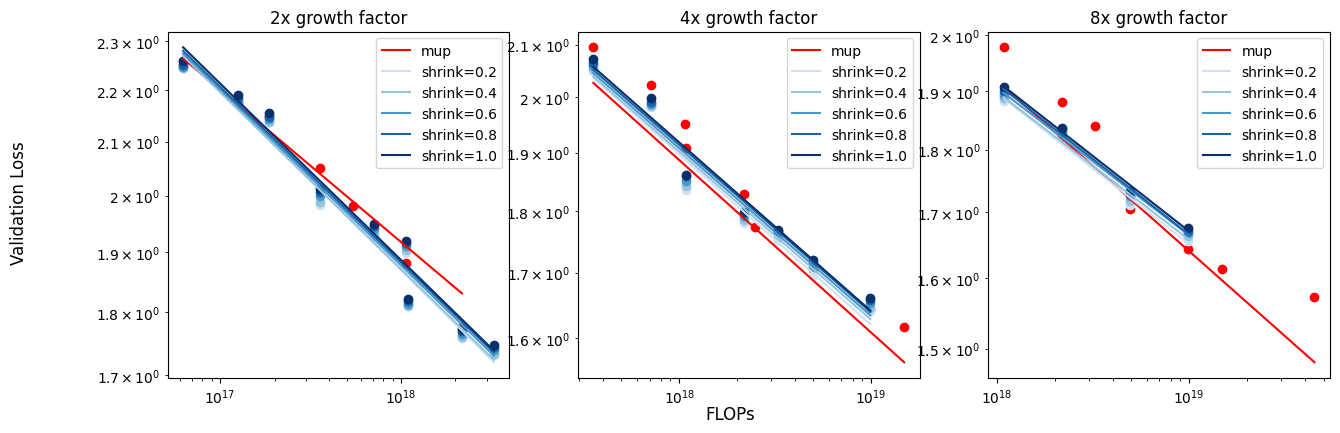

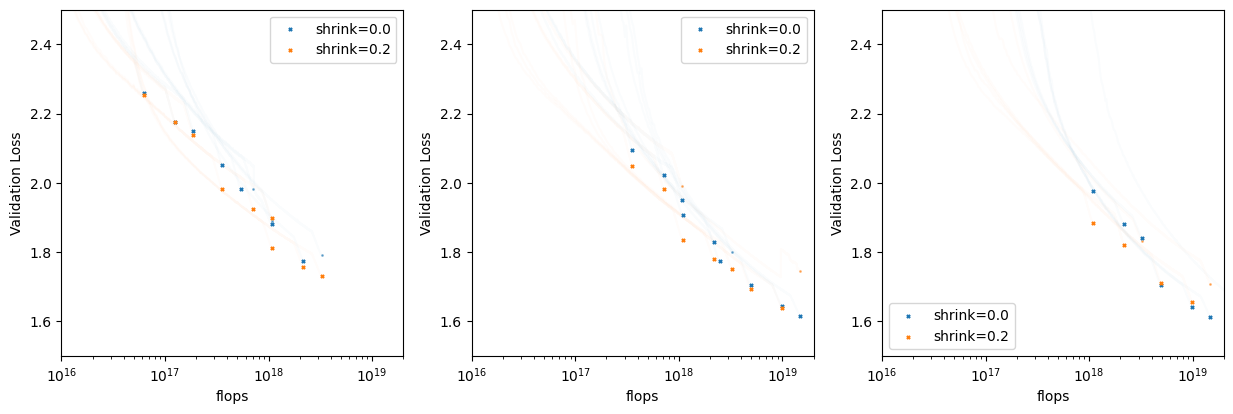

In [24]:
def filter_pairs(df, jump_size=1):
    distinct_values = sorted(
        pd.unique(df[['base_N', 'target_N']].values.ravel())
    )
    pairs = list(zip(distinct_values[:-jump_size], distinct_values[jump_size:]))
    df_filtered = df[df[['base_N', 'target_N']].apply(tuple, axis=1).isin(pairs)]
    return df_filtered

num_jump_sizes = 3
fig, axes = plt.subplots(1, num_jump_sizes, figsize=((5 * num_jump_sizes), 4.5));
fig2, axes2 = plt.subplots(1, num_jump_sizes, figsize=((5 * num_jump_sizes), 4.5));
"""
mup_df = warmstarting_df[warmstarting_df['method']=='mup']
pareto_shrink_df = get_final_points_from_curve_set(
    mup_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)
X = pareto_shrink_df[x_col].values
Y = pareto_shrink_df[y_col].values
for i in range(num_jump_sizes):
    plot_line_fit(
        axes[i],
        X,
        Y,
        slope,
        intercept,
        style={"color": "red", "label": f"mup"}
    )
"""

for i in range(num_jump_sizes):

    axes[i].set_title(f"{(2)**(i+1)}x growth factor")
    jump_df = filter_pairs(warmstarting_df, jump_size=i+1)

    shrink_factors = sorted(jump_df['shrink'].unique())
    colors = plt.cm.Blues(np.linspace(0, 1, len(shrink_factors)))
    for j, shrink in enumerate(shrink_factors):
        shrink_df = jump_df[jump_df['shrink']==shrink]
        pareto_shrink_df = get_final_points_from_curve_set(
            shrink_df,
            unique_col_list,
            x_col=x_col,
            y_col=y_col,
            get_pareto=True,
        )
            
        X = pareto_shrink_df[x_col].values
        Y = pareto_shrink_df[y_col].values

        if shrink in [0.0, 0.2]:
                    visualize_train_curves(
                        axes2[i], 
                        shrink_df,
                        unique_col_list,
                        x_col=x_col,
                        y_col=y_col,
                        plot_all_curves=True,
                        plot_final=True,
                        plot_pareto_final=True,
                        ylims=(1.5, 2.5),
                        xlims=(1e16, 2e19),
                        xlog=True,
                        style={"color": plt.get_cmap("tab10").colors[j], "label": f"shrink={shrink}"})
        
        
        # print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")
        if shrink != 0.0:
            slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
            plot_line_fit(
                axes[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": colors[j], "label": f"shrink={shrink}"})
        else:
            plot_line_fit(
                axes[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": "red", "label": f"mup"}
            )

fig.supxlabel("FLOPs")
fig.supylabel(y_col)
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

for ax in axes2.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

In [16]:
mup_df = warmstarting_df[warmstarting_df['method']=='mup']
pareto_shrink_df = get_final_points_from_curve_set(
    mup_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)

In [17]:
pareto_shrink_df

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
3185142,322633728,6.246998e+16,2.179940,2.259872,10.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.195175
3249073,645332992,1.249527e+17,1.858898,2.175067,20.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.078782
3384118,968032256,1.874353e+17,2.422664,2.150423,30.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.080489
3219542,771096576,3.568231e+17,1.947722,2.050542,10.0,32270848,77124608,0.0,512,8,0.0050,0.01,0.2,666,mup,1.928208
3174741,672399360,5.428735e+17,1.988532,1.981091,5.0,77124608,134561280,0.0,768,8,0.0025,0.01,0.2,666,mup,1.910056
3464033,2313551872,1.070591e+18,1.936146,1.880895,30.0,32270848,77124608,0.0,512,8,0.0050,0.01,0.2,666,mup,1.827524
3342692,2690777088,2.172446e+18,1.672778,1.775524,20.0,77124608,134561280,0.0,768,8,0.0025,0.01,0.2,666,mup,1.756535
3180218,1435500544,2.473511e+18,1.708724,1.773099,5.0,77124608,287183360,0.0,1280,8,0.0025,0.01,0.2,666,mup,1.742793
3228528,2871042048,4.947093e+18,1.699052,1.704930,10.0,32270848,287183360,0.0,1280,8,0.0050,0.01,0.2,666,mup,1.687401
3335848,5743116288,9.895965e+18,1.629067,1.642933,20.0,32270848,287183360,0.0,1280,8,0.0050,0.01,0.2,666,mup,1.626583


In [37]:
# if the difference is between 1.5 and 3.5 then they are close to each other
warmstarting_df[['base_N', 'target_N']].drop_duplicates()

tag,base_N,target_N
0,14562560,32270848
147720,14562560,77124608
500760,14562560,134561280
860070,14562560,287183360
1719620,14562560,610488320
1789481,32270848,77124608
1966001,32270848,134561280
2273981,32270848,287183360
2748696,77124608,134561280
2902686,77124608,287183360


In [38]:

distinct_values

for base, target in zip(distinct_values[:-1], distinct_values[1:])


SyntaxError: expected ':' (2762940776.py, line 3)

### Approach 3


In [ ]:
df = get_final_points_from_curve_set(
    warmstarting_df,
    unique_col_list,
    x_col="flops",
    y_col="Validation Loss",
    get_pareto=False,
)

N, _ = df["target_N"].values, df["tokens"].values
_D = df["target_N"] * df["tkpm"]
y = df["Validation Loss"].values

_df = pd.DataFrame.from_dict({
    "N": N,
    "D": _D,
    "Loss": y
}).groupby(by=["N", "D"]).min().reset_index()
_df.sort_values(by=["N", "D"], inplace=True)

data_X = _df[["N", "D"]].values
data_y = _df["Loss"].values

In [ ]:
initialization = list(product(
    [0, 5, 10, 15, 20, 25],  # a
    [0, 0.5, 1.0, 1.5, 2.0],  # alpha
    [0, 5, 10, 15, 20, 25],  # b
    [0, 0.5, 1.0, 1.5, 2.0],  # beta
    [-1, -0.5, 0, 0.5, 1]  # e
))

# initialization = list(product(
#     [0, 5,],  # a
#     [0, 0.5,],  # alpha
#     [0, 5, ],  # b
#     [0, 0.5,],  # beta
#     [-1, -0.5,]  # e
# ))


In [ ]:
best_params, best_loss = fit_parametric_form(
    functional_form_chin3,
    data_X, 
    data_y, 
    initialization
)

print(f"Best Loss: {best_loss}")
print(f"a: {best_params[0]}, alpha={best_params[1]}\nb: {best_params[2]}, beta={best_params[3]}\ne={best_params[4]}")

In [ ]:
_a, alpha, _b, beta, _e = best_params

A = np.exp(_a)
B = np.exp(_b)
E = np.exp(_e)

a = beta / (alpha + beta)
b = alpha / (alpha + beta)

print(a, b)

G = ((alpha*A) / (beta*B)) ** (1 / (alpha + beta))
print(G)

In [ ]:
# Creating held out over pareto df HERE
x_col = "flops"
y_col = "Validation Loss"

_pareto_df = get_final_points_from_curve_set(
    warmstarting_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True
)
train_df = _pareto_df.loc[_pareto_df.target_N != sorted(_pareto_df.target_N.unique())[-1]]
# held_out_df = _pareto_df.loc[_pareto_df.target_N == sorted(_pareto_df.target_N.unique())[-1]]
# held_out_df

In [ ]:
# plotting for N_opt

plt.clf();
fig, ax = plt.subplots(1, 3, figsize=(15, 4));

# C vs N

X = train_df[x_col].values
Y = train_df["target_N"].values
# slope, intercept = b, G / 6**a

ax[0].scatter(X, Y, label="raw data")
_x_plot = np.linspace(X.min(), X.max(), 100)
ax[0].plot(
    _x_plot, 
    # np.exp(intercept + slope * np.log(_x_plot)), 
    G * (_x_plot / 6) ** a,
    color="red", 
    label="fitted line"
    )
ax[0].loglog()

# C vs D

X = train_df[x_col].values
Y = train_df["tokens"].values
# slope, intercept = b, G / 6**a

ax[1].scatter(X, Y, label="raw data")
_x_plot = np.linspace(X.min(), X.max(), 100)
ax[1].plot(
    _x_plot, 
    # np.exp(intercept + slope * np.log(_x_plot)), 
    G**-1 * (_x_plot / 6) ** b,
    color="red", 
    label="fitted line"
    )
ax[1].loglog()